In [460]:
from binarytoydata import *
from binary_data_tools import *
import pandas as pd
import numpy as np
import math
from lineardatamodels import *
from lineartoydata import *
from lineardatatools import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## First Idea:
- Two ways to generate binary (x,t,y) data: 
    - with binary z and conditional prob. tables
    - with Gaussian z and linear + sigmoid functions
- Can we generate identical (x,t,y) distributions from these (but maybe different causal effects?)
    - First create the Gaussian z data -> use Pearls' method to reconstruct a matching data generating process with binary z
    - End result: Doesn't work, seems that with gaussian z we can generate p(x,t,y) not expressible with binary z

# Test if analytical methods work

In [302]:
num_samples = 5000000
z_expectation = torch.Tensor([0.6])
x_expectations = torch.Tensor([[0.1,0.9],
                              [0.8,0.1]])
x_dim = len(x_expectations)
t_expectations = torch.Tensor([[0.3,0.7]])
y_expectations = torch.Tensor([[0.85,0.9,0.1,0.95]])

df = binary_data_df(num_samples, z_expectation, x_expectations, t_expectations, y_expectations)

In [297]:
calculate_prob = generate_calculate_prob(z_expectation, x_expectations, t_expectations, y_expectations)
prob_df = pd.DataFrame([c + (calculate_prob(c[0], c[1:3], c[3], c[4]),) for c in itertools.product([0,1],repeat=5)], 
                       columns=['z'] + ['x{}'.format(i) for i in range(x_dim)] + ['t', 'yf', 'P'])

In [265]:
def calculate_pydot(prob_df):#Same as in the tools, just returns p(y|do(t)) instead of ATE
    true_py_do1 = 0
    true_py_do0 = 0
    for z in range(2):
        true_py_do1 += prob_df[(prob_df.yf==1)&(prob_df.z==z)&(prob_df.t==1)].P.sum()\
                   *1/prob_df[(prob_df.z==z)&(prob_df.t==1)].P.sum()\
                   *prob_df[(prob_df.z==z)].P.sum()
        true_py_do0 += prob_df[(prob_df.yf==1)&(prob_df.z==z)&(prob_df.t==0)].P.sum()\
                   *1/prob_df[(prob_df.z==z)&(prob_df.t==0)].P.sum()\
                   *prob_df[(prob_df.z==z)].P.sum()
    return true_py_do1, true_py_do0

In [266]:
print(calculate_true_ate(prob_df))
print(calculate_pydot(prob_df))

0.529999990106756
(0.9299999720597829, 0.39999998195302694)


### Estimation from exact prob dist

In [267]:
def p(var,val):
    return prob_df[(prob_df[var] == val).prod(1).map(bool)].P.sum()

In [268]:
py_x0_te1 = np.array([[p(["x0","t","yf"],(1,1,1))/p(["x0","t"],(1,1)), p(["x0","t","yf"],(0,1,1))/p(["x0","t"],(0,1))]])
px1_x0_te1 = np.array([[p(["x1","x0","t"],(1,1,1))/p(["x0","t"],(1,1)), p(["x1","x0","t"],(1,0,1))/p(["x0","t"],(0,1))],
                      [p(["x1","x0","t"],(0,1,1))/p(["x0","t"],(1,1)),p(["x1","x0","t"],(0,0,1))/p(["x0","t"],(0,1))]])
px1 = np.array([[p(["x1"],1)],[p(["x1"],0)]])

py_x0_te0 = np.array([[p(["x0","t","yf"],(1,0,1))/p(["x0","t"],(1,0)), p(["x0","t","yf"],(0,0,1))/p(["x0","t"],(0,0))]])
px1_x0_te0 = np.array([[p(["x1","x0","t"],(1,1,0))/p(["x0","t"],(1,0)), p(["x1","x0","t"],(1,0,0))/p(["x0","t"],(0,0))],
                      [p(["x1","x0","t"],(0,1,0))/p(["x0","t"],(1,0)),p(["x1","x0","t"],(0,0,0))/p(["x0","t"],(0,0))]])

print(py_x0_te1.dot(np.linalg.inv(px1_x0_te1)).dot(px1))
print(py_x0_te0.dot(np.linalg.inv(px1_x0_te0)).dot(px1))

[[0.92999997]]
[[0.39999999]]


### Estimation from data

In [303]:
def get_p2_func(df):
    def p2(var,val):
        return (df[var]==val).prod(1).sum()/len(df)
    return p2

#def p2(var, val):
#    return (df[var]==val).prod(1).sum()/len(df)

In [304]:
p2 = get_p2_func(df)
py_x0_te1 = np.array([[p2(["x0","t","yf"],(1,1,1))/p2(["x0","t"],(1,1)), p2(["x0","t","yf"],(0,1,1))/p2(["x0","t"],(0,1))]])
px1_x0_te1 = np.array([[p2(["x1","x0","t"],(1,1,1))/p2(["x0","t"],(1,1)), p2(["x1","x0","t"],(1,0,1))/p2(["x0","t"],(0,1))],
                      [p2(["x1","x0","t"],(0,1,1))/p2(["x0","t"],(1,1)),p2(["x1","x0","t"],(0,0,1))/p2(["x0","t"],(0,1))]])
px1 = np.array([[p2(["x1"],1)],[p2(["x1"],0)]])

py_x0_te0 = np.array([[p2(["x0","t","yf"],(1,0,1))/p2(["x0","t"],(1,0)), p2(["x0","t","yf"],(0,0,1))/p2(["x0","t"],(0,0))]])
px1_x0_te0 = np.array([[p2(["x1","x0","t"],(1,1,0))/p2(["x0","t"],(1,0)), p2(["x1","x0","t"],(1,0,0))/p2(["x0","t"],(0,0))],
                      [p2(["x1","x0","t"],(0,1,0))/p2(["x0","t"],(1,0)),p2(["x1","x0","t"],(0,0,0))/p2(["x0","t"],(0,0))]])

print(py_x0_te1.dot(np.linalg.inv(px1_x0_te1)).dot(px1))
print(py_x0_te0.dot(np.linalg.inv(px1_x0_te0)).dot(px1))

[[0.92995574]]
[[0.40003858]]


### Estimation with Pearl's method (recover data generating process)

In [271]:
#Case where we know p(x0|z)
t=1
y=1
V_ty_x0 = np.array([[p(["yf","x0","t"],(y,0,t))/p(["t"],t)],[p(["yf","x0","t"],(y,1,t))/p(["t"],t)]])
M_x0_z = np.array([1-x_expectations[0,:].detach().numpy(),x_expectations[0,:].detach().numpy()])#First row is x0=0
V_ty_z = np.linalg.inv(M_x0_z).dot(V_ty_x0)

V_t_x0 = np.array([[p(["x0","t"],(0,t))/p(["t"],t)],[p(["x0","t"],(1,t))/p(["t"],t)]])
V_x0 = np.array([[p(["x0"],0)],[p(["x0"],1)]])

V_t_z = np.linalg.inv(M_x0_z).dot(V_t_x0)
V_z = np.linalg.inv(M_x0_z).dot(V_x0)

sum(V_ty_z*V_z/V_t_z)

array([0.92999995])

In [273]:
#Finding out p(x0|z)
P_x1_x0 = np.array([[1,p(["x0", "t"],(0,t))/p(["t"],t), p(["x0", "t"],(0,t))/p(["t"],t)],
                   [p(["x1","t"],(0,t))/p(["t"],t), p(["x1","x0","t"],(0,0,t))/p(["t"],t),p(["x1","x0","t"],(0,1,t))/p(["t"],t)],
                   [p(["x1","t"],(1,t))/p(["t"],t) ,p(["x1","x0","t"],(1,0,t))/p(["t"],t), p(["x1","x0","t"],(1,1,t))/p(["t"],t)]])
Q_x1_x0 = np.array([[p(["yf","t"],(y,t))/p(["t"],t), p(["yf","x0","t"],(y,0,t))/p(["t"],t), p(["yf","x0","t"],(y,1,t))/p(["t"],t)],
                   [p(["yf","x1","t"],(y,0,t))/p(["t"],t), p(["yf","x1","x0","t"],(y,0,0,t))/p(["t"],t), p(["yf","x1","x0","t"],(y,0,1,t))/p(["t"],t)],
                   [p(["yf","x1","t"],(y,1,t))/p(["t"],t), p(["yf","x1","x0","t"],(y,1,0,t))/p(["t"],t), p(["yf","x1","x0","t"],(y,1,1,t))/p(["t"],t)]])
P_x1_x0[:-1,:-1]
e,v = np.linalg.eig(np.linalg.inv(P_x1_x0[:-1,:-1]).dot(Q_x1_x0[:-1,:-1]))
print(e,v)
inv = np.linalg.inv(v)
inv[:,1]*1/inv[:,0]

[0.94999999 0.89999998] [[ 0.66896472 -0.09950373]
 [-0.74329416  0.99503719]]


array([0.10000002, 0.89999998])

In [332]:
def p_x0_z_from_dist(p,y_label="y"):
    #Returns the probability of x0=0 given z=1 and z=0. The assignment to 1 and 0 is arbitrary
    t = 1
    y = 1#the valus of these don't actually matter for the final result
    P_x1_x0 = np.array([[1,p(["x0", "t"],(0,t))/p(["t"],t)],
                        [p(["x1","t"],(0,t))/p(["t"],t), p(["x1","x0","t"],(0,0,t))/p(["t"],t)]])
    Q_x1_x0 = np.array([[p([y_label,"t"],(y,t))/p(["t"],t), p([y_label,"x0","t"],(y,0,t))/p(["t"],t)],
                        [p([y_label,"x1","t"],(y,0,t))/p(["t"],t), p([y_label,"x1","x0","t"],(y,0,0,t))/p(["t"],t)]])
    e,v = np.linalg.eig(np.linalg.inv(P_x1_x0).dot(Q_x1_x0))
    e = sorted(list(enumerate(list(e))), key=lambda x: -x[1])#Just sorting the v for consistent results, probably doesn't matter
    sorted_v = np.concatenate([v[:,e[0][0]][:,None],v[:,e[1][0]][:,None]],1)
    inv = np.linalg.inv(v)
    return inv[:,1]*1/inv[:,0]

In [293]:
def everything_from_dist(p,y_label="y"):
    p_x0_0_z = p_x0_z_from_dist(p,y_label)
    p_x0_z = 1-p_x0_0_z#This is ready as is
    
    #Next figure out p(z), p(t|z),p(y|z,t)
    p_y_tz = np.zeros((2,2))#p(y=1|t,z), dims (t,z)
    p_t_z = np.zeros((2,))#p(y=1|z)
    p_x1_z = np.zeros((2,))
    p_z = np.zeros(1)
    
    for t in range(2):
        for y in range(2):
            V_ty_x0 = np.array([[p([y_label,"x0","t"],(y,0,t))/p(["t"],t)],[p([y_label,"x0","t"],(y,1,t))/p(["t"],t)]])
            V_t_x0 = np.array([[p(["x0","t"],(0,t))/p(["t"],t)],[p(["x0","t"],(1,t))/p(["t"],t)]])
            V_x0 = np.array([[p(["x0"],0)],[p(["x0"],1)]])

            M_x0_z = np.array([p_x0_0_z, p_x0_z])

            V_z = np.linalg.inv(M_x0_z).dot(V_x0)#p(z)
            V_t_z = np.linalg.inv(M_x0_z).dot(V_t_x0)
            V_ty_z = np.linalg.inv(M_x0_z).dot(V_ty_x0)
            
            p_z[0] = V_z[1,0]#Prob that "z=1"
            p_y_tz[t,:] = (V_ty_z/V_t_z).squeeze() #In order z=0 and z=1
            if t==1:
                p_t_z[:] = (V_t_z*p(["t"],1)/V_z).squeeze()
    x1 = 1
    V_x1_x0 = np.array([[p(["x0","x1"],(0,x1))/p(["x1"],x1)],[p(["x0","x1"],(1,x1))/p(["x1"],x1)]])
    M_x0_z = np.array([p_x0_0_z, p_x0_z])
    V_x1_z = np.linalg.inv(M_x0_z).dot(V_x1_x0)#p(z|x1=1) (order z=0, z=1)
    p_x1_z[:] = (V_x1_z*p(["x1"],1)/V_z).squeeze()#Reusing V_z
    
    return p_y_tz, p_t_z, p_z, p_x0_z, p_x1_z

In [294]:
everything_from_dist(p,"yf")

(array([[0.09999998, 0.85000003],
        [0.94999999, 0.89999998]]),
 array([0.70000001, 0.30000003]),
 array([0.39999997]),
 array([0.89999998, 0.10000002]),
 array([0.09999999, 0.8       ]))

In [305]:
everything_from_dist(p2,"yf")

(array([[0.10321265, 0.84903324],
        [0.95018365, 0.89986352]]),
 array([0.69953808, 0.30091649]),
 array([0.39994643]),
 array([0.90144503, 0.09830738]),
 array([0.10108753, 0.79833809]))

In [307]:
#The true parameters were:
#z_expectation = torch.Tensor([0.6])
#x_expectations = torch.Tensor([[0.1,0.9],
#                              [0.8,0.1]])
#x_dim = len(x_expectations)
#t_expectations = torch.Tensor([[0.3,0.7]])
#y_expectations = torch.Tensor([[0.85,0.9,0.1,0.95]])

# Generating binary data from Gaussian z

In [79]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

array([0])

In [80]:
def gaussianz_binary_df(num_samples, x_a, x_b, t_a, t_b, y_a0, y_b0, y_a1, y_b1):
    z = np.random.standard_normal((num_samples,1))
    x_dim = len(x_a)
    x_a = np.array(x_a)
    x_b = np.array(x_b)
    x = (np.random.random((num_samples, x_dim)) < sigmoid(x_a*z + x_b))
    t = (np.random.random((num_samples, 1)) < sigmoid(t_a*z + t_b)).astype(int)
    y = (np.random.random((num_samples, 1)) < sigmoid(y_a1*z + y_b1)).astype(int)*t \
        + (np.random.random((num_samples, 1)) < sigmoid(y_a0*z + y_b0)).astype(int)*(1-t)
    df = pd.DataFrame(np.concatenate([z,x,t,y], axis=1), 
                      columns=['z'] + ['x{}'.format(i) for i in range(x_dim)] + ['t','y'])
    return df

In [808]:
num_samples=1000000
x_a = np.array([1.4,1.4])*2
x_b = np.array([-0.2,0.4])*2
t_a = np.array([1])*2#Make this larger to amplify amplify nonlinearities
t_b = np.array([0.2])*2
y_a0 = np.array([2])*2
y_b0 = np.array([-0.6])*2
y_a1 = np.array([2])*2
y_b1 = np.array([0.6])*2

In [809]:
df2 = gaussianz_binary_df(num_samples, x_a, x_b, t_a, t_b, y_a0, y_b0, y_a1, y_b1)

In [810]:
def linear_binary_ty_pydot(p_y_zt1_func, p_y_zt0_func):
    """Calculates the ATE assuming the standard normal p(z) distribution and given P(y|z,t).
    Assumes z_dim==1 for the model."""
    p_y_dot1,_ = scipy.integrate.quad(lambda z: scipy.stats.norm.pdf(z)*p_y_zt1_func(z), -np.inf, np.inf)
    p_y_dot0,_ = scipy.integrate.quad(lambda z: scipy.stats.norm.pdf(z)*p_y_zt0_func(z), -np.inf, np.inf)
    return p_y_dot1, p_y_dot0

p_y_zt1_true, p_y_zt0_true = p_y_zt_from_true_dist(y_a0, y_b0, y_a1, y_b1)
true_ate = linear_binary_ty_ate(p_y_zt1_true, p_y_zt0_true)
print(true_ate)
print(linear_binary_ty_pydot(p_y_zt1_true, p_y_zt0_true))

0.21611171295671433
(0.6080558564783571, 0.3919441435216428)


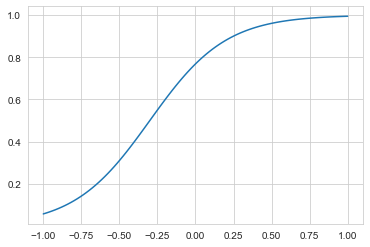

In [811]:
p_y_zt1_true(np.array([0,1]))
zrange = np.linspace(-1,1,100)
plt.plot(zrange, p_y_zt1_true(zrange))

In [812]:
p2 = get_p2_func(df2)
py_x0_te1 = np.array([[p2(["x0","t","y"],(1,1,1))/p2(["x0","t"],(1,1)), p2(["x0","t","y"],(0,1,1))/p2(["x0","t"],(0,1))]])
px1_x0_te1 = np.array([[p2(["x1","x0","t"],(1,1,1))/p2(["x0","t"],(1,1)), p2(["x1","x0","t"],(1,0,1))/p2(["x0","t"],(0,1))],
                      [p2(["x1","x0","t"],(0,1,1))/p2(["x0","t"],(1,1)),p2(["x1","x0","t"],(0,0,1))/p2(["x0","t"],(0,1))]])
px1 = np.array([[p2(["x1"],1)],[p2(["x1"],0)]])

py_x0_te0 = np.array([[p2(["x0","t","y"],(1,0,1))/p2(["x0","t"],(1,0)), p2(["x0","t","y"],(0,0,1))/p2(["x0","t"],(0,0))]])
px1_x0_te0 = np.array([[p2(["x1","x0","t"],(1,1,0))/p2(["x0","t"],(1,0)), p2(["x1","x0","t"],(1,0,0))/p2(["x0","t"],(0,0))],
                      [p2(["x1","x0","t"],(0,1,0))/p2(["x0","t"],(1,0)),p2(["x1","x0","t"],(0,0,0))/p2(["x0","t"],(0,0))]])

print(py_x0_te1.dot(np.linalg.inv(px1_x0_te1)).dot(px1))
print(py_x0_te0.dot(np.linalg.inv(px1_x0_te0)).dot(px1))

[[0.61846586]]
[[0.33117341]]


In [813]:
p_y_tz, p_t_z, p_z, p_x0_z, p_x1_z = everything_from_dist(p2,"y")
print(p_y_tz, p_t_z, p_z, p_x0_z, p_x1_z)

[[0.9381805  0.04228069]
 [0.96903584 0.35434741]] [0.90270008 0.25724473] [0.53095397] [0.8106237  0.13414001] [0.97572593 0.25939466]


In [814]:
print(p_y_tz[0,0]*(1-p_z) + p_y_tz[0,1]*p_z)
print(p_y_tz[1,0]*(1-p_z) + p_y_tz[1,1]*p_z)

[0.46249894]
[0.64266458]


In [815]:
#z_expectation = torch.Tensor([0.6])
#x_expectations = torch.Tensor([[0.1,0.9],
#                              [0.8,0.1]])
#x_dim = len(x_expectations)
#t_expectations = torch.Tensor([[0.3,0.7]])
#y_expectations = torch.Tensor([[0.85,0.9,0.1,0.95]])

df3 = binary_data_df(1000000, 
                    torch.Tensor(p_z),
                    torch.Tensor([p_x0_z,p_x1_z]),
                    torch.Tensor([p_t_z]),
                    torch.Tensor([[p_y_tz[0,0],p_y_tz[1,0],p_y_tz[0,1],p_y_tz[1,1]]]))

calculate_prob = generate_calculate_prob(torch.Tensor(p_z), torch.Tensor([p_x0_z,p_x1_z]), 
                                         torch.Tensor([p_t_z]), torch.Tensor([[p_y_tz[0,0],p_y_tz[1,0],p_y_tz[0,1],p_y_tz[1,1]]]))
prob_df3 = pd.DataFrame([c + (calculate_prob(c[0], c[1:3], c[3], c[4]),) for c in itertools.product([0,1],repeat=5)], 
                       columns=['z'] + ['x{}'.format(i) for i in range(x_dim)] + ['t', 'yf', 'P'])

In [816]:
_, dist_data, dist_exact = getJointDistributions(torch.Tensor([[0,0,0,0,0]]), df3[['x0','x1','t','yf']],prob_df3)

In [817]:
dist_data_original = getJointDistFromDataFrame(df2[['x0','x1','t','y']])
(dist_exact.P - dist_data_original.P).abs().sum()

0.10246287947026836

In [800]:
display(dist_data_original)
dist_exact

,x0,x1,t,y,P
0,0,0,0,0,0.251419
1,0,0,0,1,0.006966
2,0,0,1,0,0.050503
3,0,0,1,1,0.032777
4,0,1,0,0,0.075205
5,0,1,0,1,0.015727
6,0,1,1,0,0.028147
7,0,1,1,1,0.086911
8,1,0,0,0,0.022336
9,1,0,0,1,0.004669


,x0,x1,t,yf,P
0,0,0,0,0,0.241309
1,0,0,0,1,0.011018
2,0,0,1,0,0.056421
3,0,0,1,1,0.032917
4,0,1,0,0,0.085315
5,0,1,0,1,0.011675
6,0,1,1,0,0.022229
7,0,1,1,1,0.086771
8,1,0,0,0,0.037061
9,1,0,0,1,0.002522


# Second idea:
- Two categoricals: z with binary values and z with four values or eight
    - First define the completely binary distribution
    - Then figure out data generating process for more complex z that matches the binary z p(x,t,y) distribution
- Probably larger z allows flexibility in explaining the data -> can match to different causal effects
    - What happens if we increase the number of proxies? Would the causal effect have to match at some point?

In [66]:
def binary_data_df_catZ(num_samples, z_prob, x_prob, t_prob, y_prob):
    """x_prob is (n_z,dim_x), t_prob is (n_z,) and y_prob is (n_z,2) (for different t)"""
    n_z = len(z_prob)
    dim_x = x_prob.shape[1]
    z = np.random.multinomial(1,z_prob,num_samples)
    x = np.zeros((num_samples, dim_x))
    for i in range(dim_x):
        probs = (x_prob[:,i]*z).sum(1)
        x[:,i] = (np.random.rand() > probs).astype(int)
    probs_t = (t_prob*z).sum(1)
    t = (np.random.rand() > probs_t).astype(int)
    probs_y_t0 = (y_prob[:,0]*z).sum(1)
    y0 = (np.random.rand() > probs_y_t0).astype(int)
    probs_y_t1 = (y_prob[:,1]*z).sum(1)
    y1 = (np.random.rand() > probs_y_t1).astype(int)
    y = y1*t + y0*(1-t)
    return z,x,t,y

# Third idea:
- Does CEVAE actually work for binary (z,x,t,y)? (does the gaussian+sigmoid data generating process include the binary z process?)
- Maybe could test the previous idea by using CEVAE for the more complex categorical z